### Driving disembodied networks with inputs to see how neural activity evolves
Specifically, we'd like to see if integrator is driven by reward, visual cue, odor, or something else

In [1]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch.distributions.utils import logits_to_probs
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split_augmented import A2CRNNAugmented
from agents.networks.gru_rnn import GRU_RNN
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write, logical_and, format_plot
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from numpy.linalg import norm
from imblearn.under_sampling import RandomUnderSampler


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# SUBNETWORK PARAMS
SUB_HIDDEN_SIZE = 32
SUB_INPUT_SIZE = 2
SUB_OUTPUT_SIZE = 1

plt.rcParams['font.family'] = 'Helvetica Light'

C:\Users\david.bell\work\favorably_connected\code\notebooks


In [2]:
# Load weights from given `load_path`
def load_network(load_path):
    subnetwork = GRU_RNN(
        input_size=SUB_INPUT_SIZE,
        hidden_size=SUB_HIDDEN_SIZE,
        output_size=SUB_OUTPUT_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    network = A2CRNNAugmented(
        subnetwork=subnetwork,
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    with torch.no_grad():
        saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
        if 'network_state_dict' in saved_checkpoint:
            network.load_state_dict(saved_checkpoint['network_state_dict'])
        else:
            network.load_state_dict(saved_checkpoint)
        network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data

In [3]:
weight_paths = [
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00050.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00100.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00150.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00200.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00250.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00300.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/00500.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/01000.pth',
    # 'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/01500.pth',
    'train_augmented_rnn_pretrained_2025-02-21_00_09_16_185395_var_noise_0.0001_activity_weight_1/rnn_weights/02000.pth',
]

hidden_and_behavior_paths = [
    # 'test_augment_pretrain_2025-03-13_22_23_41_484413_var_noise_0_activity_weight_0_sn_00050',
    # 'test_augment_pretrain_2025-03-13_22_29_02_566759_var_noise_0_activity_weight_0_sn_00100',
    # 'test_augment_pretrain_2025-03-13_22_34_23_777244_var_noise_0_activity_weight_0_sn_00150',
    # 'test_augment_pretrain_2025-03-13_22_39_01_813740_var_noise_0_activity_weight_0_sn_00200',
    # 'test_augment_pretrain_2025-03-13_22_50_57_641228_var_noise_0_activity_weight_0_sn_00250',
    # 'test_augment_pretrain_2025-03-13_22_55_59_298068_var_noise_0_activity_weight_0_sn_00300',
    # 'test_augment_pretrain_2025-03-21_13_56_11_433378_var_noise_0_activity_weight_0_sn_00500',
    # 'test_augment_pretrain_2025-03-21_14_00_24_563438_var_noise_0_activity_weight_0_sn_01000',
    # 'test_augment_pretrain_2025-03-21_14_16_30_328359_var_noise_0_activity_weight_0_sn_01500',
    'test_augment_pretrain_2025-03-21_13_41_00_398273_var_noise_0_activity_weight_0_sn_02000',
]

In [4]:
for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    hidden_activities, pc_activities, all_session_data = load_hidden_and_behavior(hidden_and_behavior_path)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']


In [5]:
print(hidden_activities.shape)

(160, 120, 20000)


In [54]:
print(len(all_session_data))

120


In [5]:
def extract_state_on_visual_cue(hidden_activity, session_data):
    visual_cue_went_high_mask = logical_and(
        session_data['obs'][:, 0] > 0,
        np.roll(session_data['obs'][:, 0], 1) < 1,
    )
    return hidden_activity[:, visual_cue_went_high_mask]

In [6]:
visual_cue_states = extract_state_on_visual_cue(hidden_activities[:, 0, :], all_session_data[0])

In [8]:
print(visual_cue_states.shape)

(160, 261)


In [9]:
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))

In [10]:
cos_sims = []
for i in range(visual_cue_states.shape[1]):
    if i > 0:
        for j in range(i):
            cos_sims.append(cosine(visual_cue_states[:, i], visual_cue_states[:, j]))
        

In [11]:
print(np.mean(cos_sims))

0.9963856


In [13]:
hs_ctrl = hidden_activities[:, 0, np.random.randint(0, 20000, size=261)]

cos_sims = []
for i in range(hs_ctrl.shape[1]):
    if i > 0:
        for j in range(i):
            cos_sims.append(cosine(hs_ctrl[:, i], hs_ctrl[:, j]))
            

In [7]:
subnetwork_hidden = hidden_activities[-32:, ...]

print(subnetwork_hidden.shape)

flattened_ha = subnetwork_hidden.reshape(subnetwork_hidden.shape[0], subnetwork_hidden.shape[1] * subnetwork_hidden.shape[2], order='C')

print(flattened_ha.shape)

pca = PCA()
pc_activities = pca.fit_transform(flattened_ha.T)
pc_activities = pc_activities.T.reshape(subnetwork_hidden.shape, order='C')

(32, 120, 20000)
(32, 2400000)


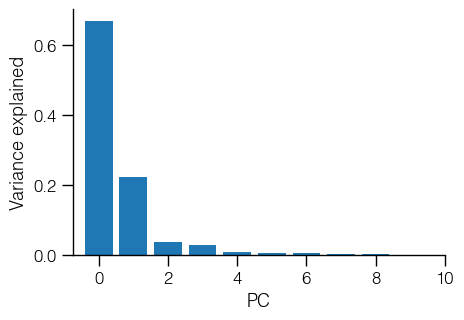

In [8]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

explained_variance_ratios = pca.explained_variance_ratio_
axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)

[<Axes: xlabel='Time'> <Axes: xlabel='Time', ylabel='PC'>]


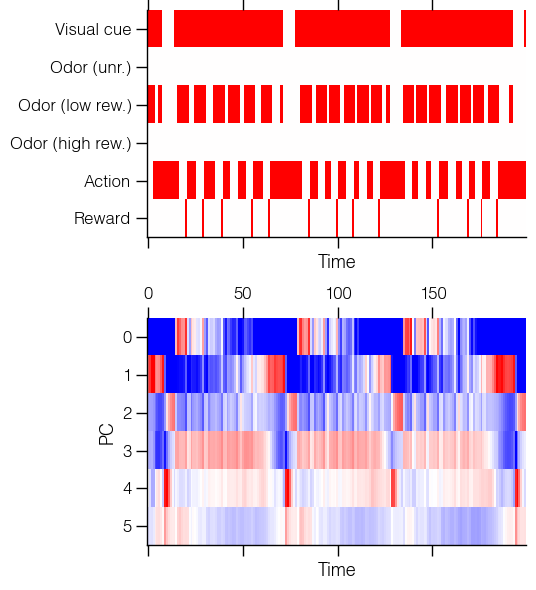

In [8]:
window = slice(1800, 2000)

scale = 1
fig, axs = plt.subplots(2, 1, figsize=(6 * scale, 6 * scale), sharex=True)
axs[1].matshow(pc_activities[:6, 0, window], cmap='bwr', vmin=-1, vmax=1, aspect=20)
axs[1].set_ylabel('PC')
axs[1].set_xlabel('Time')

inputs = np.concatenate([all_session_data[0]['obs'][window, :], all_session_data[0]['action'][window, np.newaxis], all_session_data[0]['reward'][window, np.newaxis]], axis=1).T
axs[0].matshow(inputs, cmap='bwr', vmin=-1, vmax=1, aspect=20)
axs[0].set_yticks(np.arange(6), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Action', 'Reward'])
axs[0].set_xlabel('Time')

format_plot(axs)
fig.tight_layout()

In [9]:
network_states, subnetwork_states = visual_cue_states[:HIDDEN_SIZE, :].T, visual_cue_states[HIDDEN_SIZE:, :].T
dummy_critic_states = torch.from_numpy(np.zeros_like(network_states))

network_states = torch.from_numpy(network_states)
subnetwork_states = torch.from_numpy(subnetwork_states)

In [18]:
def run_input_exp(network, inputs, t_steps=300, action_feedback=False, selected_trial=0, window=None):
    with torch.no_grad():
    
        network.set_state(
            network_states,
            dummy_critic_states,
            subnetwork_states,
        )
        
        all_hidden_out = torch.empty((t_steps, visual_cue_states.shape[0], visual_cue_states.shape[1]))
        integrator_inputs = torch.empty((t_steps, SUB_INPUT_SIZE, visual_cue_states.shape[1]))
        integrator_output = torch.zeros((t_steps, SUB_OUTPUT_SIZE, visual_cue_states.shape[1]))
        action_probs = torch.empty((t_steps, ACTION_SIZE, visual_cue_states.shape[1]))
        action_probs_running_sum = torch.zeros((t_steps, ACTION_SIZE, visual_cue_states.shape[1]))
        
        for i in range(t_steps):
            action, value, hidden_out = network.forward(inputs[i, ...])
            all_hidden_out[i, ...] = hidden_out.T
            sub_inputs = network.proj_to_subnetwork(hidden_out[:, :HIDDEN_SIZE])
            integrator_inputs[i, ...] = sub_inputs.T
            sub_output, _ = network.subnetwork(sub_inputs.unsqueeze(2), stateful=False)
            integrator_output[i, ...] = sub_output.T
            action_logits = network.action_arm(hidden_out[:, :HIDDEN_SIZE])
            action_logits -= action_logits.logsumexp(dim=-1, keepdim=True)
            action_probs[i, ...] = logits_to_probs(action_logits).T
            if i > 0:
                action_probs_running_sum[i, ...] = action_probs_running_sum[i-1, ...]
            action_probs_running_sum[i, ...] += action_probs[i, ...]
    
            if action_feedback:
                action = np.argmax(action_probs[i, ...].detach(), axis=0)
                inputs[i, np.arange(action.shape[0]), OBS_SIZE + action] = 1
            
        
        scale = 0.8
        fig, axs = plt.subplots(7, 1, figsize=(9 * scale, 12 * scale), sharex=True)
        axs[1].matshow(all_hidden_out.detach()[..., selected_trial].T[:HIDDEN_SIZE, :], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
        axs[2].matshow(all_hidden_out.detach()[..., selected_trial].T[HIDDEN_SIZE:, :], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
    
        axs[3].matshow(pca.transform(all_hidden_out.detach()[..., selected_trial][:, HIDDEN_SIZE:]).T[:6, :], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
    
        axs[0].matshow(inputs[:, 0, np.array([0, 1, 2, 3, 4, 5, 6])].T, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
    
        m = np.abs(integrator_inputs.detach()).max()
        axs[4].matshow(integrator_inputs.detach()[..., selected_trial].T, aspect='auto', cmap='bwr', vmin=-m, vmax=m)
    
        m = np.abs(integrator_output.detach()).max()
        axs[5].matshow(integrator_output.detach()[..., selected_trial].T, aspect='auto', cmap='bwr', vmin=-m, vmax=m)
            
        m = np.abs(action_probs.detach()).max()
        print(m)
        axs[6].matshow(action_probs.detach()[..., selected_trial].T, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
    
        if window:
            axs[0].set_xlim(*window)
    
        axs[0].set_yticks(np.arange(7), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Stay', 'Run', 'Reward'])
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Input')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Unit activity\n(RNN)')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel('Unit activity\n(subnetwork)')
        axs[2].set_yticks([0, 32])
        axs[3].set_xlabel('Time')
        axs[3].set_ylabel('PC')
        axs[4].set_yticks(np.arange(2), ['Integrate', 'Reset'])
        axs[5].set_yticks(np.arange(1), ['Integrated\nsum'])
        axs[6].set_yticks(np.arange(2), ['Stay', 'Leave'])
        format_plot(axs)
        fig.tight_layout()
    
        scale = 0.8
        fig, axs = plt.subplots(1, 1, figsize=(9 * scale, 3 * scale), sharex=True)
        axs.plot(np.arange(t_steps), action_probs_running_sum.detach()[:, 0, selected_trial], color='blue')
        axs.plot(np.arange(t_steps), action_probs_running_sum.detach()[:, 0, selected_trial], color='red')

tensor(1.0000)
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(subnetwork)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


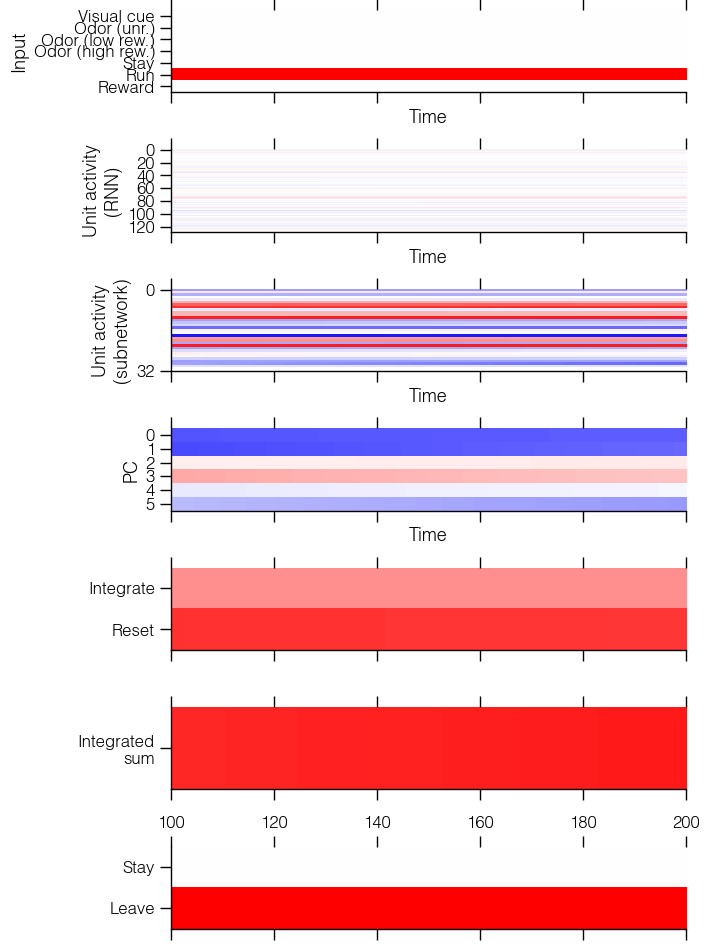

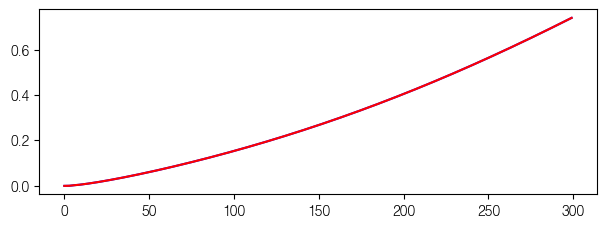

In [19]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
run_input_exp(network, inputs, t_steps, action_feedback=True, window=(100, 200))

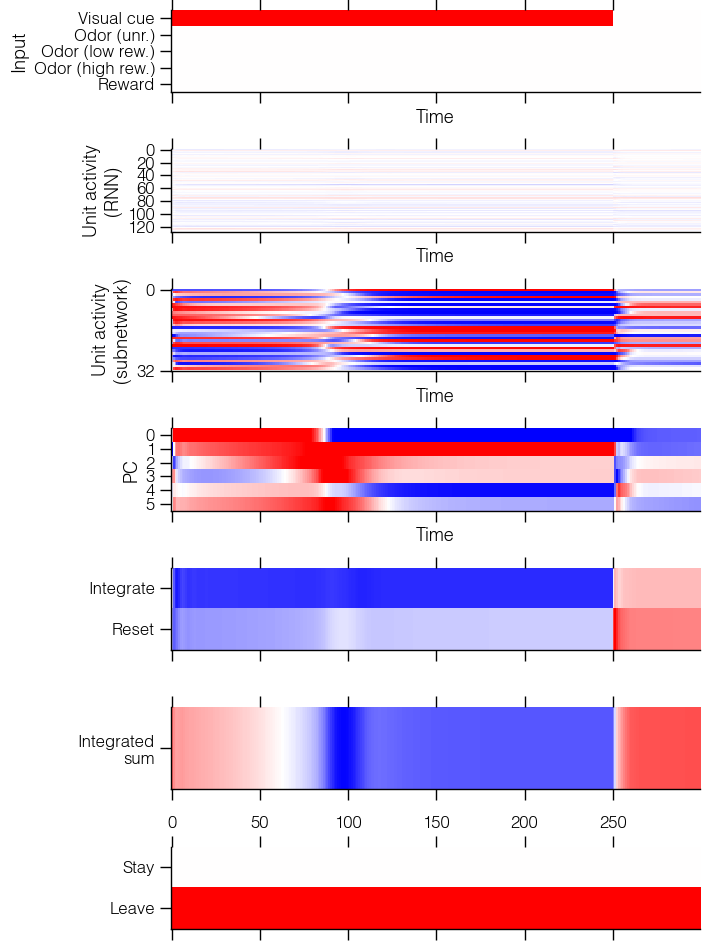

In [37]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
run_input_exp(network, inputs, t_steps)

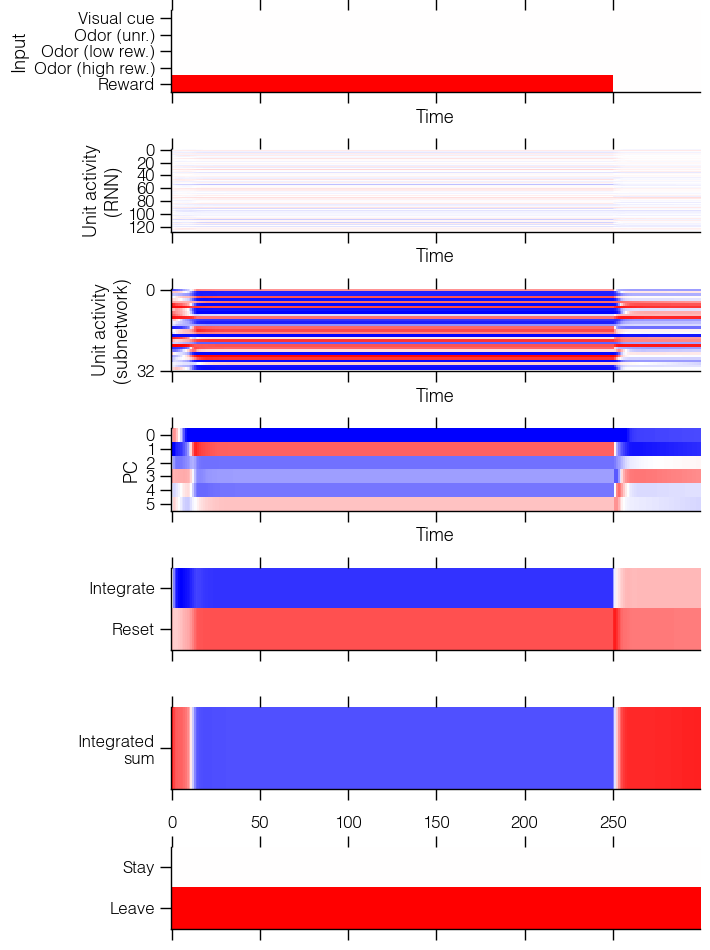

In [85]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 6] = 1
run_input_exp(network, inputs, t_steps)

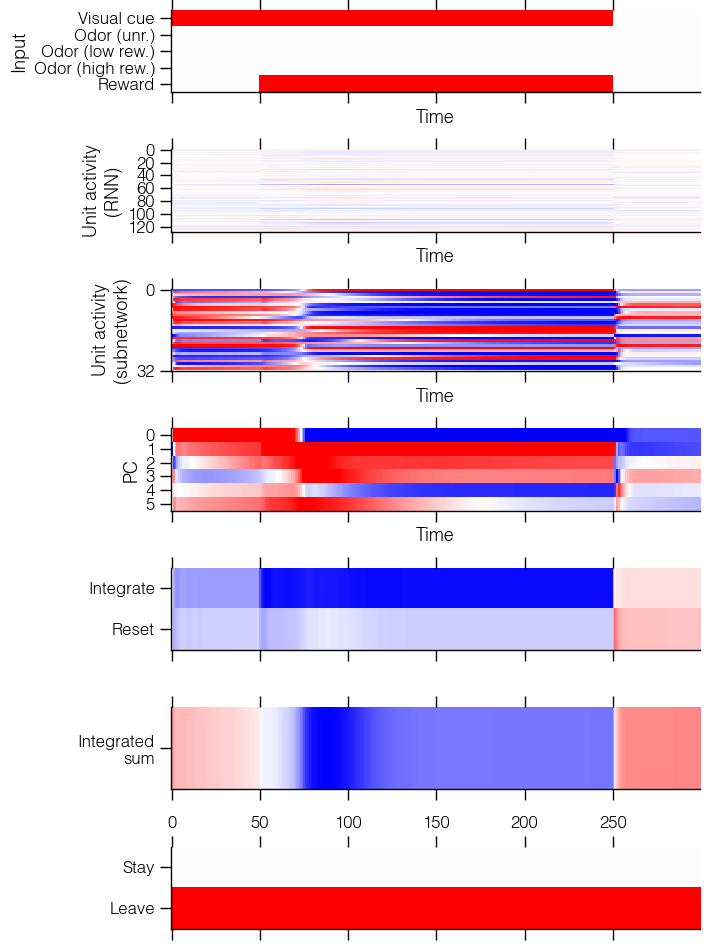

In [86]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[50:250, :, 6] = 1
run_input_exp(network, inputs, t_steps)

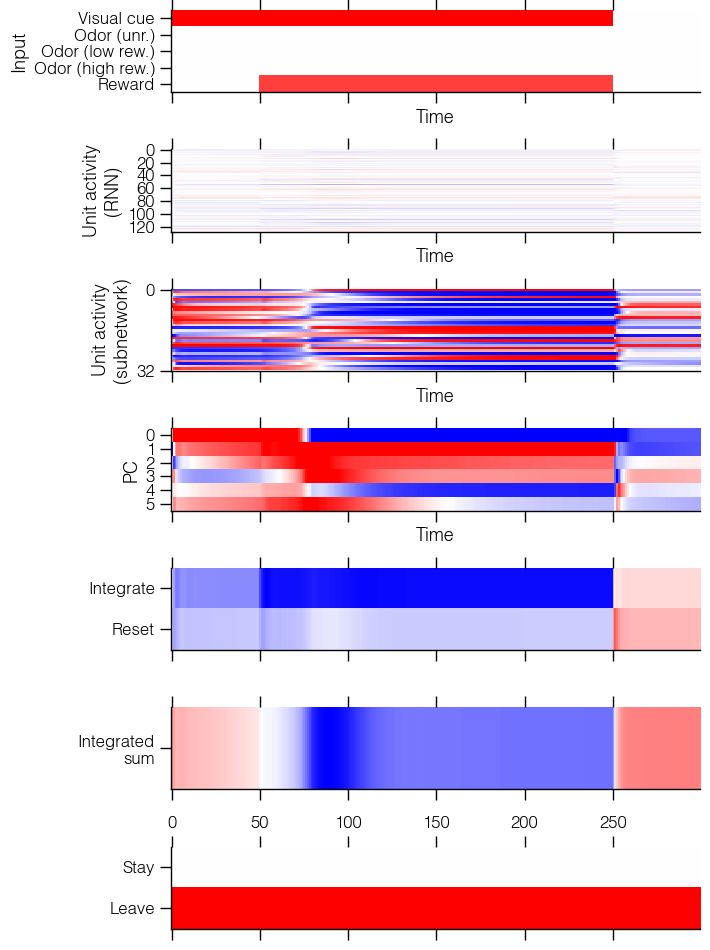

In [87]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:250, :, 6] = 0.75
run_input_exp(network, inputs, t_steps)

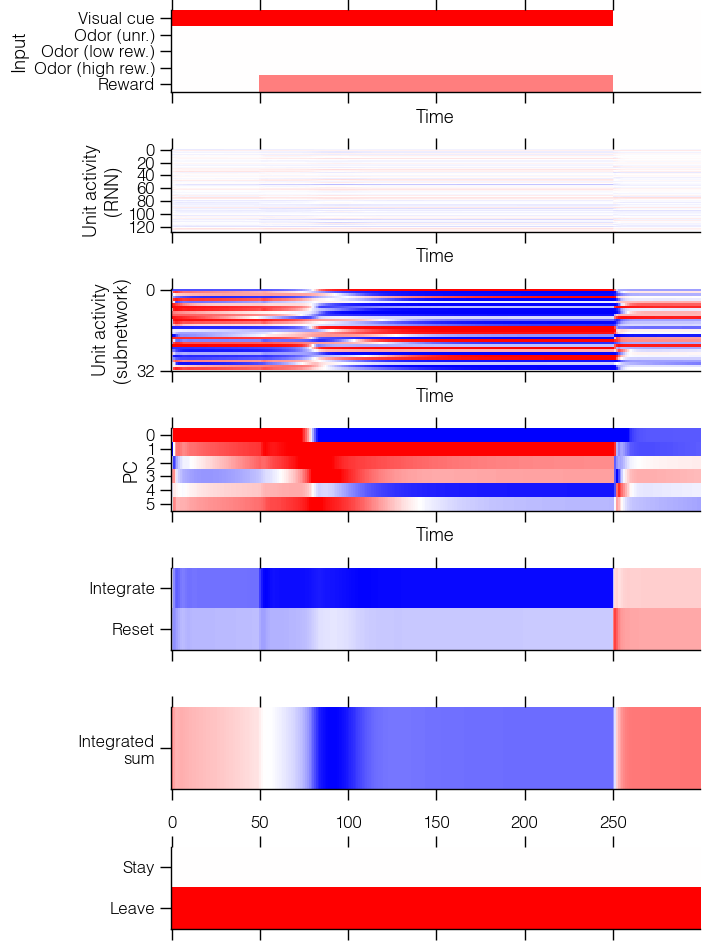

In [88]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:250, :, 6] = 0.5
run_input_exp(network, inputs, t_steps)

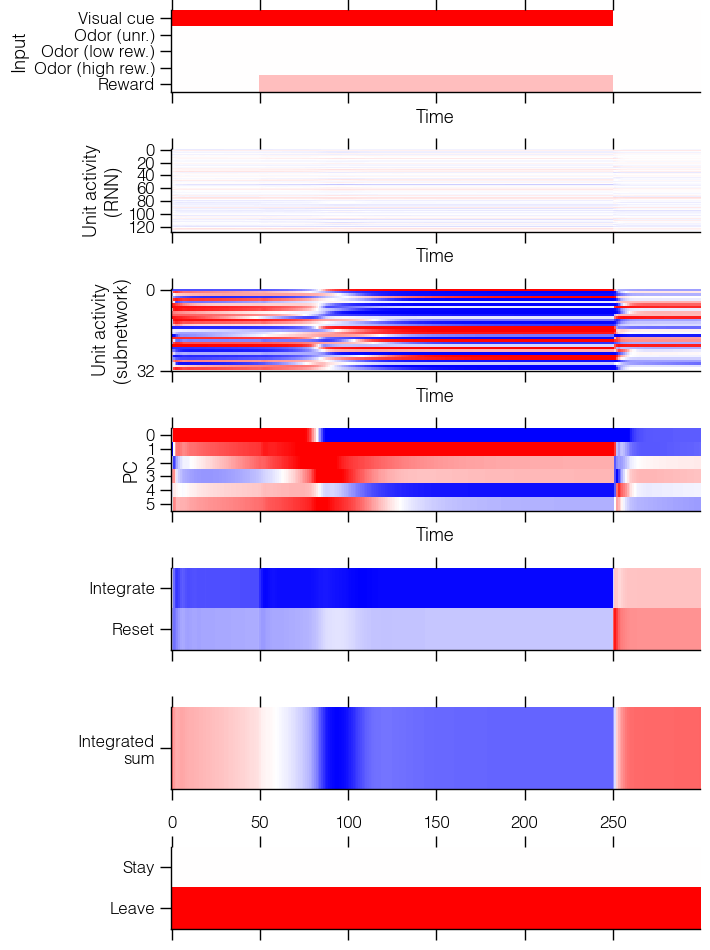

In [89]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:250, :, 6] = 0.25
run_input_exp(network, inputs, t_steps)

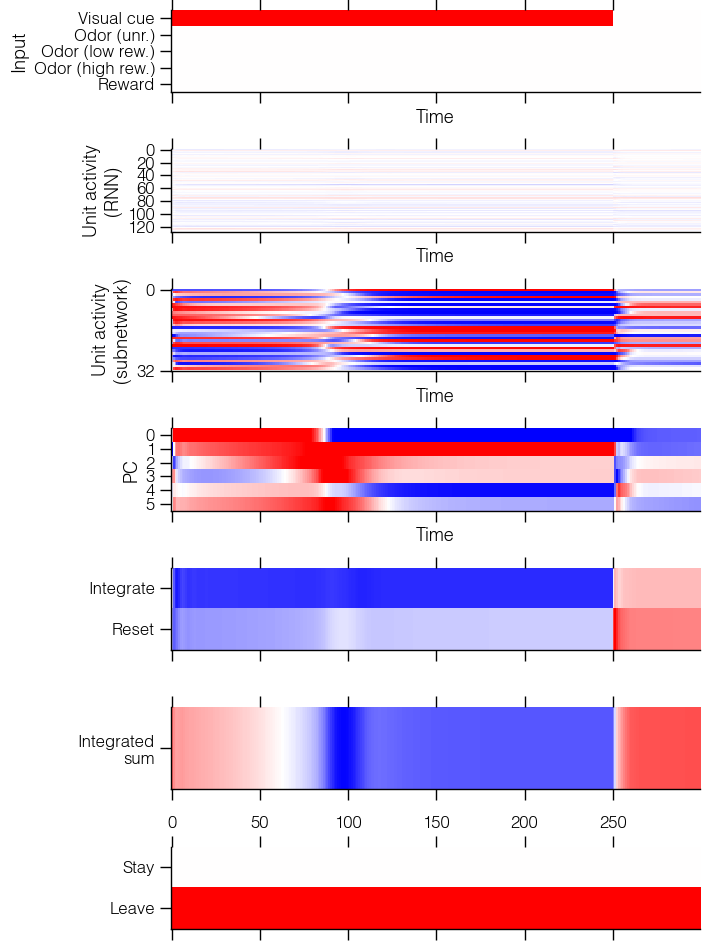

In [90]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:50, :, 6] = 1
run_input_exp(network, inputs, t_steps)

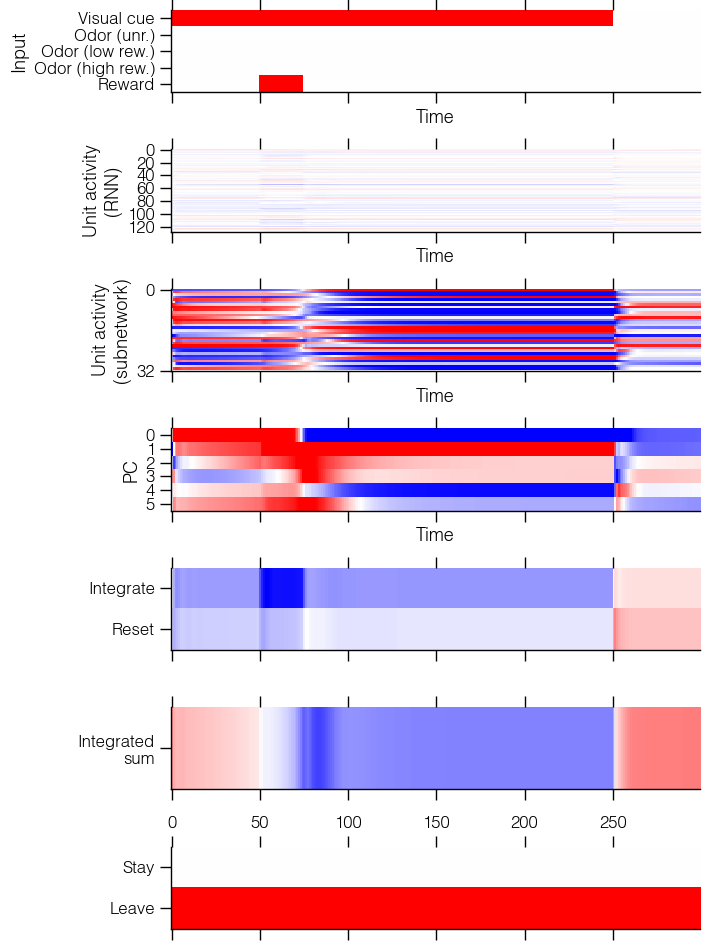

In [91]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:75, :, 6] = 1
run_input_exp(network, inputs, t_steps)

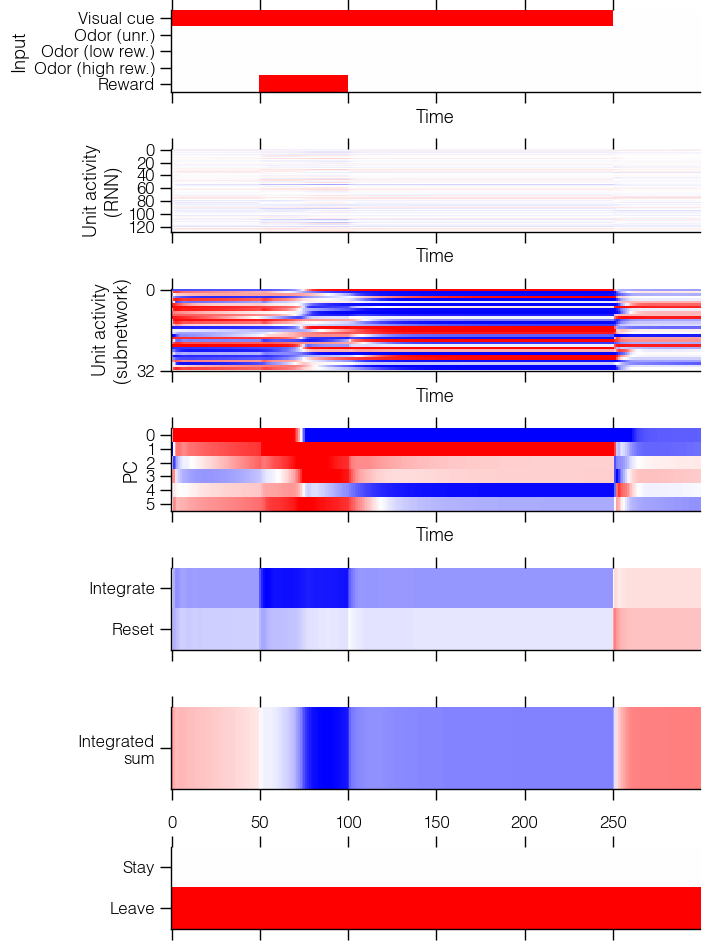

In [92]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:100, :, 6] = 1
run_input_exp(network, inputs, t_steps)

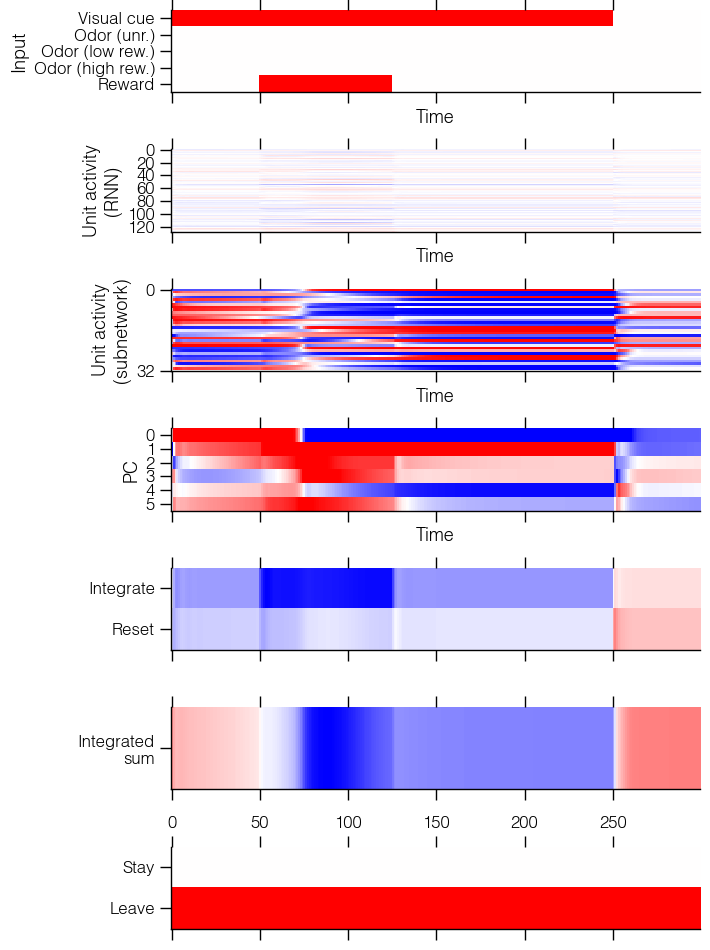

In [93]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:125, :, 6] = 1
run_input_exp(network, inputs, t_steps)

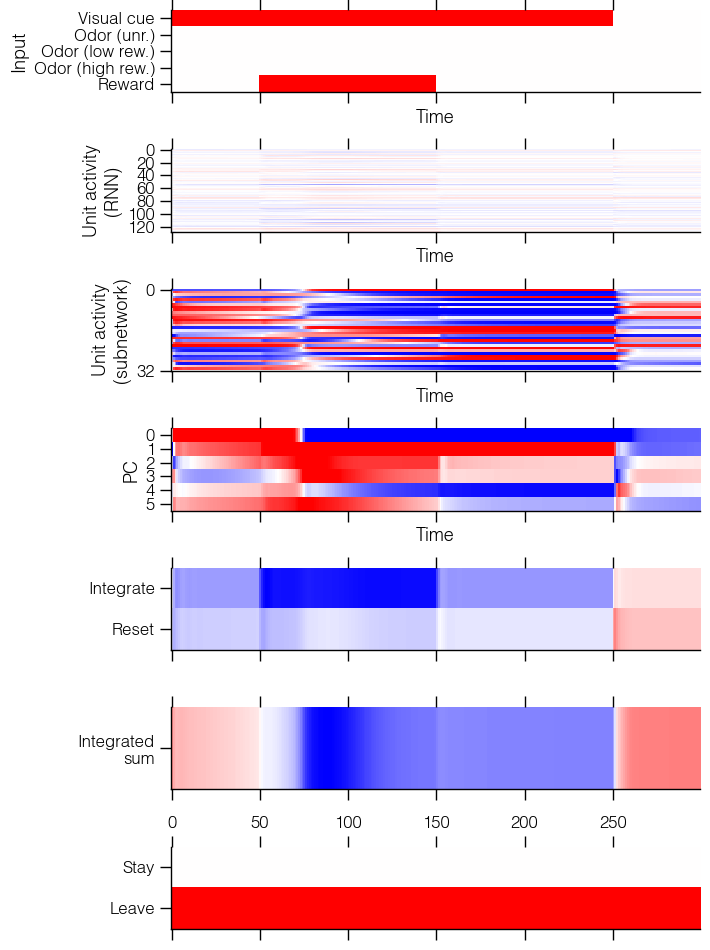

In [94]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:150, :, 6] = 1
run_input_exp(network, inputs, t_steps)

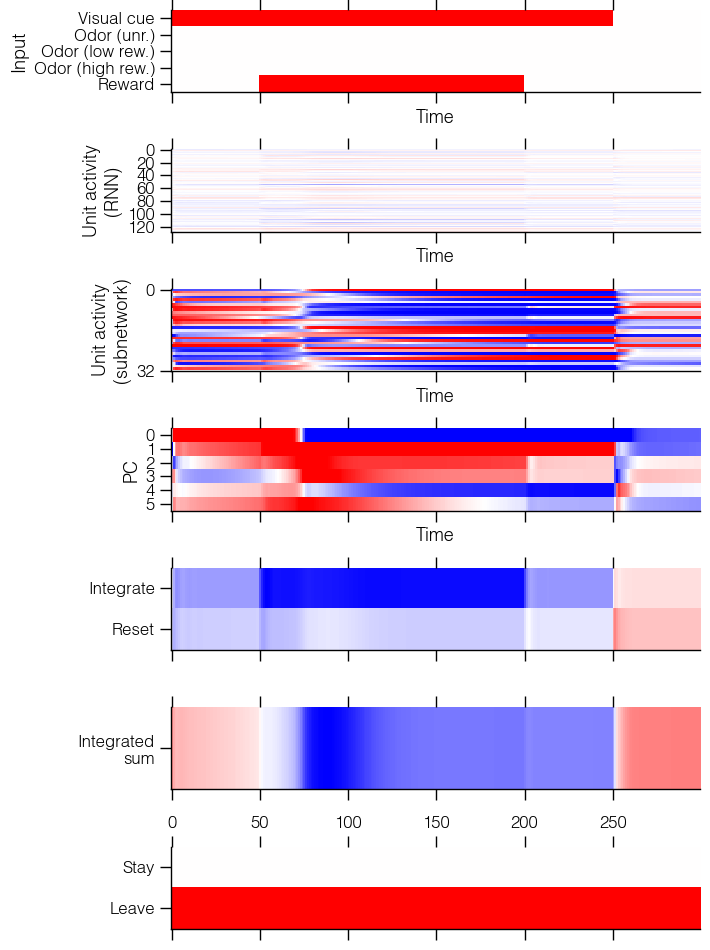

In [95]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[0:250, :, 0] = 1
inputs[50:200, :, 6] = 1
run_input_exp(network, inputs, t_steps)

tensor(1.)


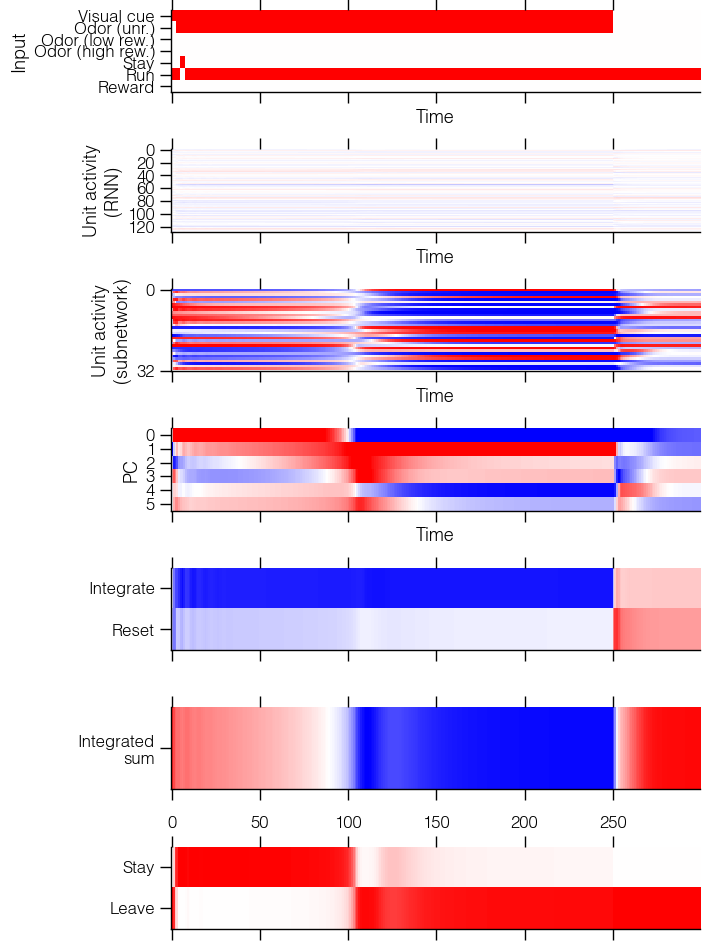

In [11]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[3:250, :, 1] = 1
run_input_exp(network, inputs, t_steps, action_feedback=True, selected_trial=21)

tensor(1.)
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(subnetwork)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


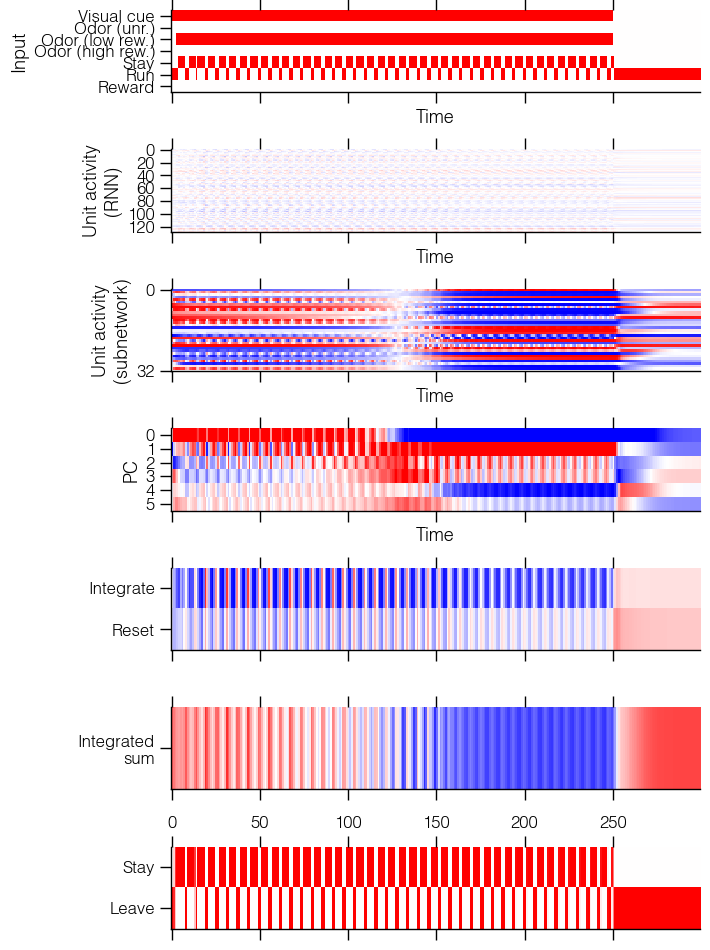

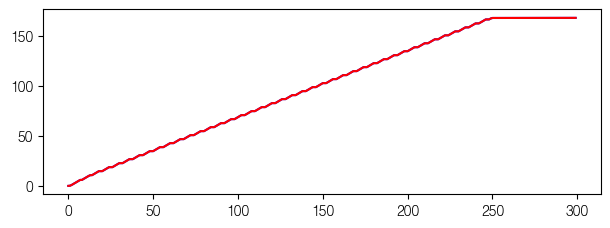

In [21]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[3:250, :, 2] = 1
run_input_exp(network, inputs, t_steps, action_feedback=True, selected_trial=21)

tensor(1.)
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(subnetwork)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


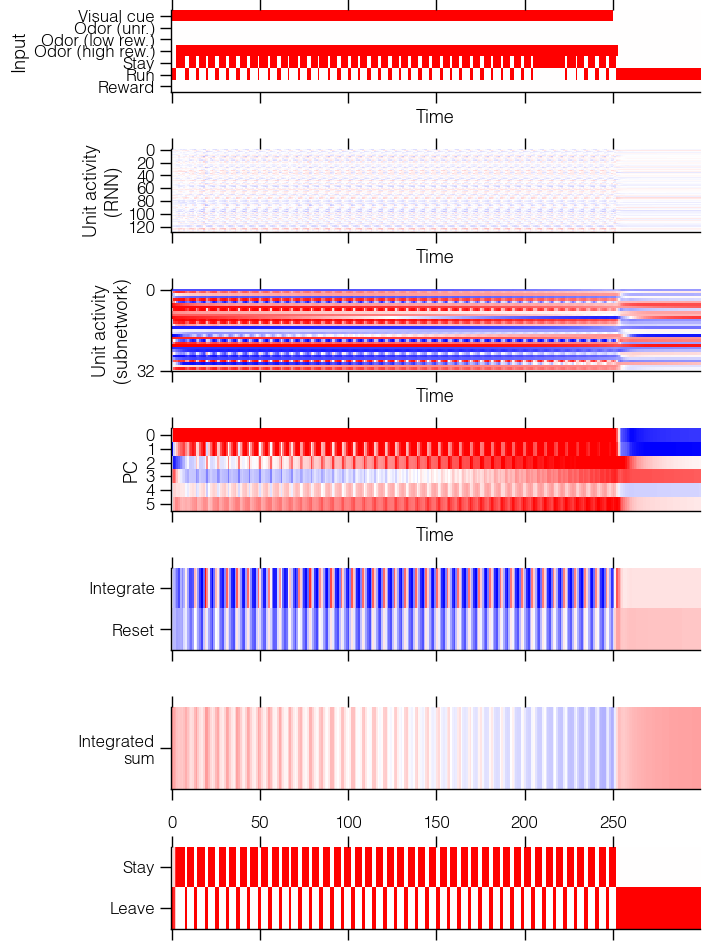

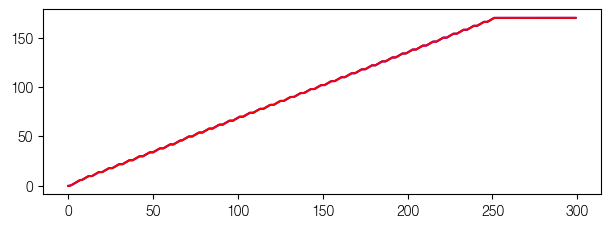

In [20]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
inputs[3:253, :, 3] = 1
run_input_exp(network, inputs, t_steps, action_feedback=True, selected_trial=21)

In [22]:
def append_pulsed_input(inputs, index, onset, n_cycles, on_period, off_period):
    v = np.empty(int(n_cycles * (on_period + off_period)))
    for c in range(n_cycles):
        period_start = onset + (on_period + off_period) * c
        inputs[period_start : period_start + on_period, :, index] = 1
        inputs[period_start + on_period : period_start + on_period + off_period, :, index] = 0

tensor(1.)
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(subnetwork)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


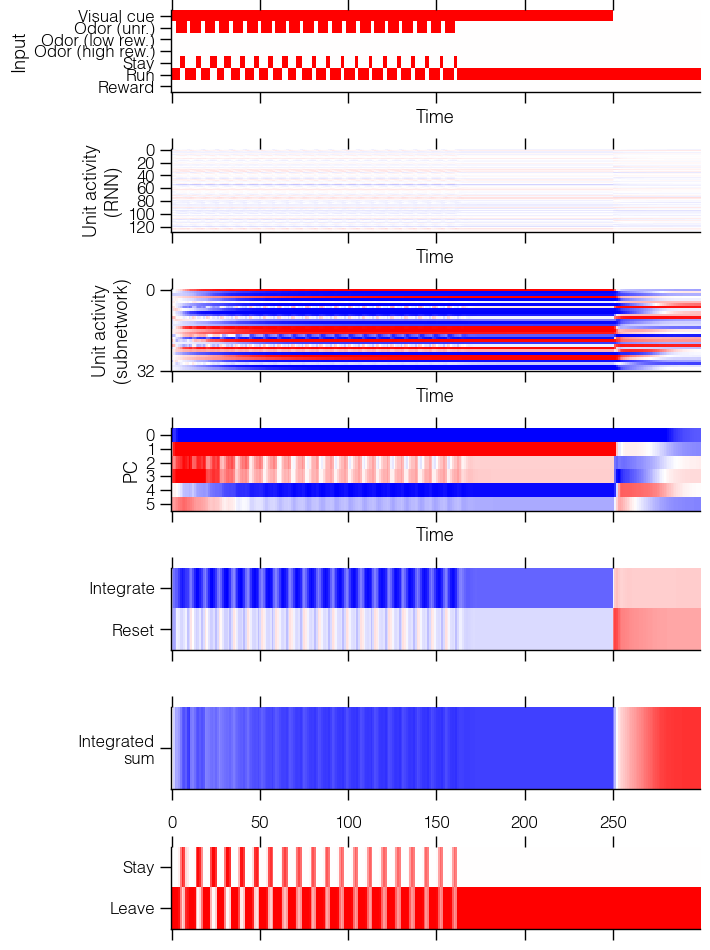

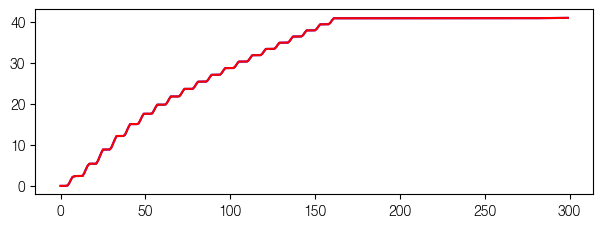

In [23]:
t_steps = 300
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:250, :, 0] = 1
append_pulsed_input(inputs, index=1, onset=3, n_cycles=20, on_period=6, off_period=2)
run_input_exp(network, inputs, t_steps, action_feedback=True)

tensor(1.)
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(subnetwork)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


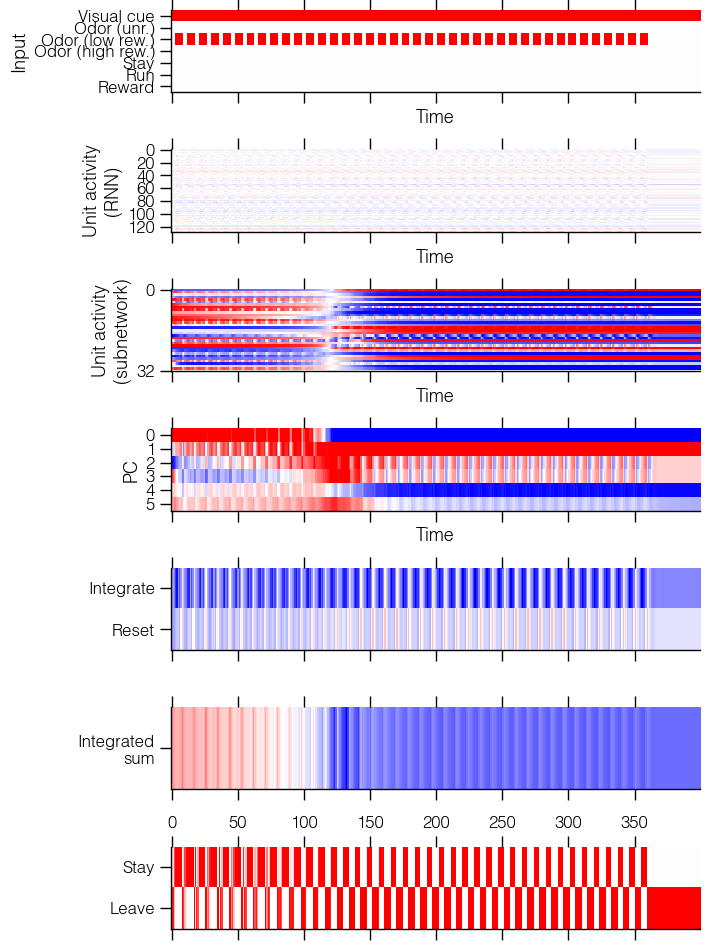

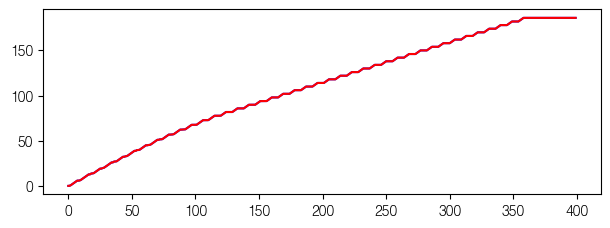

In [33]:
t_steps = 400
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:400, :, 0] = 1
append_pulsed_input(inputs, index=2, onset=3, n_cycles=40, on_period=6, off_period=3)
run_input_exp(network, inputs, t_steps, action_feedback=False, selected_trial=100)

tensor(1.)
[<Axes: xlabel='Time', ylabel='Input'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(RNN)'>
 <Axes: xlabel='Time', ylabel='Unit activity\n(subnetwork)'>
 <Axes: xlabel='Time', ylabel='PC'> <Axes: > <Axes: > <Axes: >]


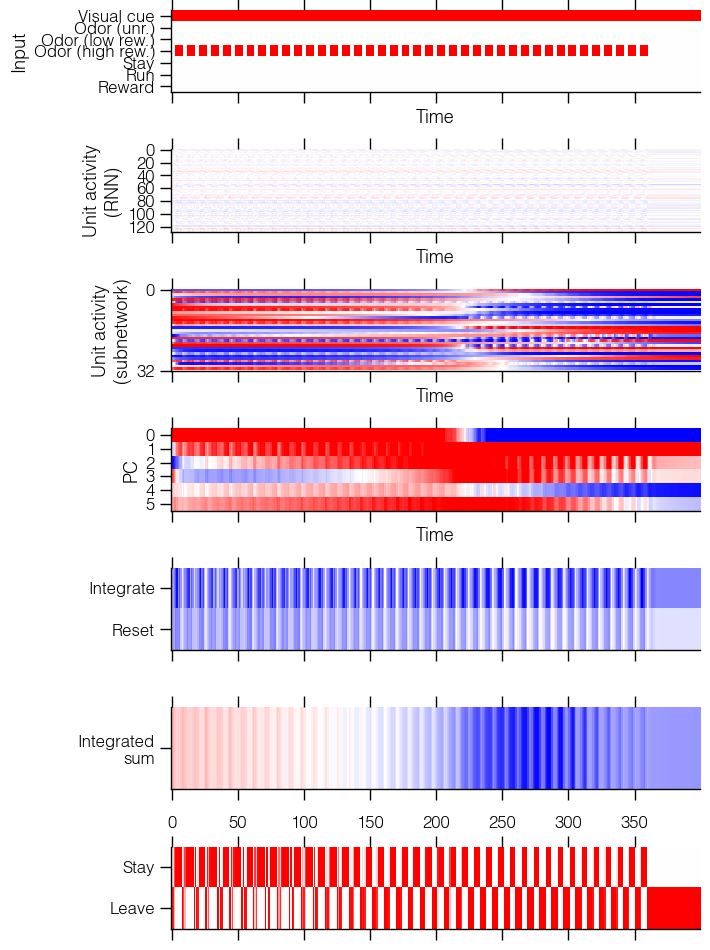

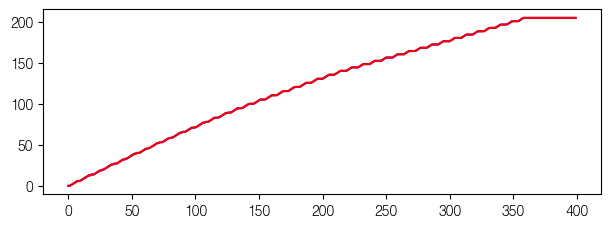

In [32]:
t_steps = 400
inputs = torch.zeros(t_steps, network_states.shape[0], OBS_SIZE + ACTION_SIZE + 1)
inputs[:400, :, 0] = 1
append_pulsed_input(inputs, index=3, onset=3, n_cycles=40, on_period=6, off_period=3)
# append_pulsed_input(inputs, index=6, onset=3, n_cycles=50, on_period=1, off_period=7)
run_input_exp(network, inputs, t_steps, action_feedback=False, selected_trial=100)